In [141]:
# Investigating which classes suffer from test-time augmentation,
# and why
import sys
sys.path.insert(0, '../')
from dataloaders import get_imnet_dataloader
from utils.gpu_utils import restrict_GPU_pytorch
restrict_GPU_pytorch('0')

import h5py
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from imagenet_classes import imagenet_classes


sns.set_style('white')
hf = h5py.File('../imnet/five_crop_hflip_scale/model_outputs/val/resnet50.h5', 'r')
outputs = []
labels = []
for key in hf.keys():
    if 'inputs' in key:
        batch_key = key
        label_key = key[:-7] + "_labels"
        outputs.append(hf[batch_key][:])
        labels.append(hf[label_key][:])
outputs = np.concatenate(outputs, axis=1)
labels = np.concatenate(labels)

Using GPU:0


In [142]:
from sklearn.model_selection import train_test_split
train_idxs, test_idxs = train_test_split(list(range(outputs.shape[1])), train_size=.5, 
                                        stratify=labels)
train_outputs, train_labels = outputs[:,train_idxs,:], labels[train_idxs]
test_outputs, test_labels = outputs[:,test_idxs,:], labels[test_idxs]

In [143]:
# identify which predicted classes are hurt by standard TTA
orig_idx = 12
stta_preds = np.mean(train_outputs, axis=0)
orig_preds = train_outputs[orig_idx,:,:]

stta_correct_idxs = np.where(np.argmax(stta_preds, axis=1) == train_labels)[0]
stta_incorrect_idxs = np.where(np.argmax(stta_preds, axis=1) != train_labels)[0]
orig_correct_idxs = np.where(np.argmax(orig_preds, axis=1) == train_labels)[0]
orig_incorrect_idxs = np.where(np.argmax(orig_preds, axis=1) != train_labels)[0]

In [144]:
train_corruptions = list(set(stta_incorrect_idxs).intersection(orig_correct_idxs))
train_corrections = list(set(stta_correct_idxs).intersection(orig_incorrect_idxs))

train_corrupt_predicted_classes = np.argmax(stta_preds[train_corruptions], axis= 1)
train_correct_predicted_classes = np.argmax(stta_preds[train_corrections], axis= 1)
len(train_corruptions), len(train_corrections)

(494, 715)

In [145]:
corrupt_map = np.zeros(1000)
correct_map = np.zeros(1000)
for j in train_corrupt_predicted_classes:
    corrupt_map[j] += 1

for j in train_correct_predicted_classes:
    correct_map[j] += 1

In [171]:
diffs = correct_map - corrupt_map
classes_to_avoid = np.where(diffs < 0)[0]
classes_to_avoid = np.argsort(np.var(cm, axis=1))[-100:]

(array([  1.,  11.,  49., 150.,   0., 429., 254.,  71.,  30.,   5.]),
 array([-4. , -3.2, -2.4, -1.6, -0.8,  0. ,  0.8,  1.6,  2.4,  3.2,  4. ]),
 <BarContainer object of 10 artists>)

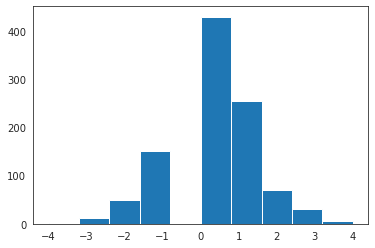

In [172]:
plt.hist(correct_map - corrupt_map)

In [173]:
stta_test_preds = np.mean(test_outputs, axis=0)
orig_test_preds = test_outputs[orig_idx,:,:]
combined_test_preds = []
for i in range(len(stta_test_preds)):
    stta_pred = stta_test_preds[i]
    orig_pred = orig_test_preds[i]
    if np.argmax(stta_pred) in classes_to_avoid:
        combined_test_preds.append(orig_pred)
    else:
        combined_test_preds.append(stta_pred)
combined_test_preds = np.array(combined_test_preds)

In [174]:
# Evaluate combined test preds against stta and orig
stta_correct_idxs = np.where(np.argmax(stta_test_preds, axis=1) == test_labels)[0]
stta_incorrect_idxs = np.where(np.argmax(stta_test_preds, axis=1) != test_labels)[0]

combined_correct_idxs = np.where(np.argmax(combined_test_preds, axis=1) == test_labels)[0]
combined_icorrect_idxs = np.where(np.argmax(combined_test_preds, axis=1) != test_labels)[0]

orig_correct_idxs = np.where(np.argmax(orig_test_preds, axis=1) == test_labels)[0]
orig_incorrect_idxs = np.where(np.argmax(orig_test_preds, axis=1) != test_labels)[0]

combined_corruptions = list(set(combined_icorrect_idxs).intersection(orig_correct_idxs))
combined_corrections = list(set(combined_correct_idxs).intersection(orig_incorrect_idxs))
test_stta_corruptions = list(set(stta_incorrect_idxs).intersection(orig_correct_idxs))
test_stta_corrections = list(set(stta_correct_idxs).intersection(orig_incorrect_idxs))
(len(combined_corruptions), len(combined_corrections)), (len(test_stta_corruptions), len(test_stta_corrections))

((468, 716), (491, 764))

In [175]:
print(len(orig_correct_idxs)/25000, len(stta_correct_idxs)/25000, len(combined_correct_idxs)/25000)

0.75592 0.76684 0.76584


In [157]:
# Based on confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(orig_preds, axis=1), train_labels)

array([0.528471, 0.529424, 0.365516, 0.497216, 0.485424, 0.332559,
       0.301424, 0.401516, 0.6011  , 0.624375, 0.577324, 0.576375,
       0.579216, 0.576375, 0.528471, 0.625324, 0.529424, 0.529424,
       0.531324, 0.624375, 0.400559, 0.444375, 0.576375, 0.533216,
       0.575424, 0.484471, 0.262471, 0.370471, 0.590039, 0.629216,
       0.539216, 0.586159, 0.148711, 0.449216, 0.228639, 0.293216,
       0.156559, 0.524976, 0.528471, 0.534271, 0.244559, 0.532271,
       0.442471, 0.576375, 0.401516, 0.288711, 0.276159, 0.360639,
       0.538271, 0.262559, 0.417324, 0.529424, 0.401516, 0.591911,
       0.302375, 0.282471, 0.403424, 0.489324, 0.237424, 0.365516,
       0.150639, 0.420159, 0.179676, 0.3256  , 0.386375, 0.538159,
       0.185676, 0.348039, 0.210471, 0.532271, 0.489324, 0.489216,
       0.421216, 0.086831, 0.403775, 0.5371  , 0.532271, 0.4571  ,
       0.290639, 0.3616  , 0.577324, 0.441516, 0.492159, 0.528471,
       0.529424, 0.538271, 0.402471, 0.575424, 0.531324, 0.580